In [1]:
! gdown --folder https://drive.google.com/drive/folders/1FoLQD8IzTg9tYYRZXOd-iIvXdijn-GSs?usp=drive_link
! gdown --folder https://drive.google.com/drive/folders/1_Q3g8Yzres8E4yRLwkO31fAMjTGNPo0i

Retrieving folder list
Processing file 1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy bd_test.h5
Processing file 1DRKofqVdn2ioh44M45eYZHl_XAW9r3v4 bd_valid.h5
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy
To: /content/bd/bd_test.h5
100% 398M/398M [00:01<00:00, 247MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DRKofqVdn2ioh44M45eYZHl_XAW9r3v4
To: /content/bd/bd_valid.h5
100% 716M/716M [00:02<00:00, 287MB/s]
Download completed
Retrieving folder list
Processing file 1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt test.h5
Processing file 1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf valid.h5
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt
To: /content/cl/test.h5
100% 398M/398M [00:01<00:00, 285MB/s]
Downloading...
From: https://drive.google.

In [2]:
! git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 220 (delta 37), reused 17 (delta 17), pack-reused 178
Receiving objects: 100% (220/220), 83.78 MiB | 10.28 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [3]:
import os
from keras.models import load_model

import h5py
import numpy as np
import keras
from tensorflow.keras.models import Model
from typing import List

model_folder = 'CSAW-HackML-2020/lab3/models'
bad_net = load_model(os.path.join(model_folder, 'bd_net.h5'))
bad_net.load_weights(os.path.join(model_folder, 'bd_weights.h5'))

In [4]:
bad_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

### Testing function as taken from CSAW-HackML-2020 repo

In [5]:
def test(model, data):
    # data = h5py.File('cl/valid.h5', 'r')
    x_test, y_test = np.array(data['data']),  np.array(data['label'])
    x_test = x_test.transpose((0,2,3,1))

    clean_label_p = np.argmax(model.predict(x_test), axis=1)
    class_accu = np.mean(np.equal(clean_label_p, y_test))*100
    return class_accu


### Clean accuracy

In [6]:
data = h5py.File('cl/valid.h5', 'r')
base_accu = test(bad_net, data)
print(f'Base accuracy: {base_accu}')
data = h5py.File('bd/bd_valid.h5', 'r')
base_attack_rate = test(bad_net, data)
print(f'Base attack rate: {base_attack_rate}')

361/361 [==============================] - 8s 2ms/step
Base accuracy: 98.64899974019225
361/361 [==============================] - 1s 2ms/step
Base attack rate: 100.0


In [7]:
def max_pooling_activations(model, layer_name, validation_dataset):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-9].output)
    activations = intermediate_layer_model.predict(validation_dataset)
    return activations

### Get the activations

In [8]:
with h5py.File('cl/valid.h5', 'r') as hf:
    x_data = np.array(hf['data'])
    y_data = np.array(hf['label'])
    x_data = x_data.transpose((0,2,3,1))
    activations = max_pooling_activations(bad_net, 'pool_3', x_data)

361/361 [==============================] - 1s 2ms/step


In [9]:
num_channels = bad_net.get_layer('pool_3').output_shape

In [10]:
## average activation values per channel
avg_act = np.mean(activations, axis=(0, 1, 2))
## reverse it for decreasing order
activation_order = np.argsort(avg_act)

### Pruning method

In [11]:
from tqdm import tqdm

def defend_badnet(thresholds: List):
    run = True
    # channel_idx = 0
    accuracies = []
    attack_rate = []
    cl_data = h5py.File('cl/valid.h5', 'r')
    bd_data = h5py.File('bd/bd_valid.h5', 'r')

    for channel_idx in tqdm(range(num_channels[-1])):
        prune_channel_num = activation_order[channel_idx]
        weights, bias = bad_net.get_layer('conv_3').get_weights()
        ## set the weights to zero
        weights[..., prune_channel_num] = np.zeros(weights[..., prune_channel_num].shape)
        bias[prune_channel_num] = 0

        bad_net.get_layer('conv_3').set_weights([weights, bias])
        ## calculate the accuracy on clean validation data
        pruned_accu = test(bad_net, cl_data)
        ## calculate the attack success rate, causing the model to misclassify
        pruned_attack_rate = 100 - test(bad_net, bd_data)
        print(f'Pruned accuracy: {pruned_accu} Pruned attack rate: {pruned_attack_rate}')
        accuracies.append(pruned_accu)
        attack_rate.append(pruned_attack_rate)

        if base_accu - pruned_accu > thresholds[0]:
            if len(thresholds) == 1:
                break
            else:
                bad_net.save('bprime_'+str(thresholds[0])+'.h5')
                thresholds = thresholds[1:]

        ## Test accuracy
    bad_net.save('bprime_'+str(thresholds[0])+'.h5')
    return accuracies, attack_rate

# rem_index = np.unravel_index(np.argmin(avg_activations, axis=None), avg_activations.shape)

In [12]:
thresholds = [2, 4, 10]
accuracies, attack_rate = defend_badnet(thresholds)

  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 2ms/step


  2%|▏         | 1/60 [00:05<05:27,  5.56s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


  3%|▎         | 2/60 [00:11<05:21,  5.54s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


  5%|▌         | 3/60 [00:16<05:17,  5.57s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


  7%|▋         | 4/60 [00:22<05:13,  5.60s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


  8%|▊         | 5/60 [00:27<05:07,  5.59s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 10%|█         | 6/60 [00:33<05:02,  5.61s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 12%|█▏        | 7/60 [00:39<05:05,  5.77s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 13%|█▎        | 8/60 [00:45<04:56,  5.70s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 15%|█▌        | 9/60 [00:50<04:50,  5.70s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 17%|█▋        | 10/60 [00:56<04:44,  5.69s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 18%|█▊        | 11/60 [01:02<04:36,  5.65s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 20%|██        | 12/60 [01:07<04:30,  5.63s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 22%|██▏       | 13/60 [01:13<04:25,  5.64s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 23%|██▎       | 14/60 [01:19<04:19,  5.65s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 25%|██▌       | 15/60 [01:24<04:13,  5.64s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 27%|██▋       | 16/60 [01:30<04:09,  5.67s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 28%|██▊       | 17/60 [01:35<04:02,  5.64s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 30%|███       | 18/60 [01:41<03:56,  5.64s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 32%|███▏      | 19/60 [01:47<03:51,  5.64s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 33%|███▎      | 20/60 [01:52<03:46,  5.65s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 35%|███▌      | 21/60 [01:58<03:39,  5.64s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 37%|███▋      | 22/60 [02:04<03:35,  5.66s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 38%|███▊      | 23/60 [02:09<03:29,  5.65s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 40%|████      | 24/60 [02:15<03:22,  5.63s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 42%|████▏     | 25/60 [02:21<03:17,  5.65s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 43%|████▎     | 26/60 [02:26<03:10,  5.60s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 45%|████▌     | 27/60 [02:32<03:04,  5.60s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 47%|████▋     | 28/60 [02:37<03:00,  5.63s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 48%|████▊     | 29/60 [02:43<02:54,  5.62s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 50%|█████     | 30/60 [02:49<02:48,  5.60s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 52%|█████▏    | 31/60 [02:54<02:43,  5.63s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 53%|█████▎    | 32/60 [03:00<02:37,  5.62s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 55%|█████▌    | 33/60 [03:06<02:31,  5.63s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 57%|█████▋    | 34/60 [03:11<02:26,  5.64s/it]

Pruned accuracy: 98.64033948211657 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 58%|█████▊    | 35/60 [03:17<02:20,  5.62s/it]

Pruned accuracy: 98.64033948211657 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 60%|██████    | 36/60 [03:22<02:14,  5.60s/it]

Pruned accuracy: 98.63167922404088 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 62%|██████▏   | 37/60 [03:28<02:08,  5.61s/it]

Pruned accuracy: 98.65765999826795 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 63%|██████▎   | 38/60 [03:33<02:02,  5.58s/it]

Pruned accuracy: 98.64899974019225 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 65%|██████▌   | 39/60 [03:39<01:56,  5.54s/it]

Pruned accuracy: 98.6056984498138 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 67%|██████▋   | 40/60 [03:45<01:51,  5.59s/it]

Pruned accuracy: 98.57105741751104 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 68%|██████▊   | 41/60 [03:50<01:44,  5.53s/it]

Pruned accuracy: 98.53641638520828 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 70%|███████   | 42/60 [03:55<01:38,  5.49s/it]

Pruned accuracy: 98.19000606218066 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 72%|███████▏  | 43/60 [04:01<01:33,  5.50s/it]

Pruned accuracy: 97.65307006148784 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 73%|███████▎  | 44/60 [04:06<01:27,  5.49s/it]

Pruned accuracy: 97.50584567420108 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 75%|███████▌  | 45/60 [04:12<01:22,  5.53s/it]

Pruned accuracy: 95.75647354291158 Pruned attack rate: 0.0
361/361 [==============================] - 1s 2ms/step


 77%|███████▋  | 46/60 [04:18<01:17,  5.52s/it]

Pruned accuracy: 95.20221702606739 Pruned attack rate: 0.00866025807569315
361/361 [==============================] - 1s 2ms/step


 78%|███████▊  | 47/60 [04:23<01:11,  5.52s/it]

Pruned accuracy: 94.7172425738287 Pruned attack rate: 0.00866025807569315
361/361 [==============================] - 1s 2ms/step


 80%|████████  | 48/60 [04:29<01:06,  5.53s/it]

Pruned accuracy: 92.09318437689443 Pruned attack rate: 0.00866025807569315
361/361 [==============================] - 1s 2ms/step


 82%|████████▏ | 49/60 [04:34<01:01,  5.57s/it]

Pruned accuracy: 91.49562656967177 Pruned attack rate: 0.00866025807569315
361/361 [==============================] - 1s 2ms/step


 83%|████████▎ | 50/60 [04:40<00:55,  5.56s/it]

Pruned accuracy: 91.01931237550879 Pruned attack rate: 0.0173205161513863
361/361 [==============================] - 1s 2ms/step


 85%|████████▌ | 51/60 [04:45<00:49,  5.53s/it]

Pruned accuracy: 89.17467740538669 Pruned attack rate: 19.260413960336024
361/361 [==============================] - 1s 2ms/step


 85%|████████▌ | 51/60 [04:51<00:51,  5.71s/it]

Pruned accuracy: 84.43751623798389 Pruned attack rate: 22.984324932883


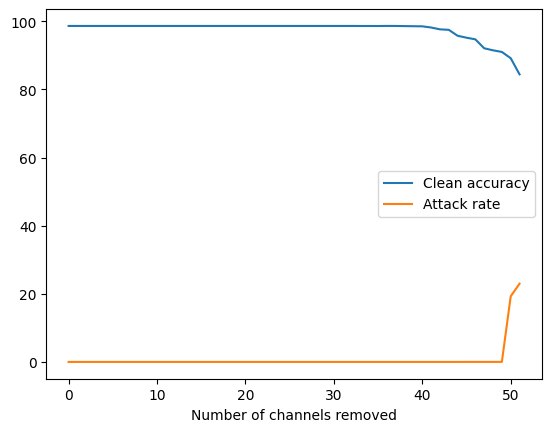

In [23]:
from matplotlib import pyplot as plt
plt.plot(range(len(accuracies)), accuracies)
plt.plot(range(len(attack_rate)), attack_rate)
plt.legend(['Clean accuracy', 'Attack rate'])
plt.xlabel('Number of channels removed')
plt.show()

## Creating the Goodnet for pruning defense

In [24]:
b = load_model(os.path.join(model_folder, 'bd_net.h5'))
b.load_weights(os.path.join(model_folder, 'bd_weights.h5'))

In [25]:
N = b.get_layer('output').output_shape[-1]

In [26]:
class G(keras.Model):
  def __init__(self, B, B_pruned):
      super(G, self).__init__()
      self.B = B
      self.B_pruned = B_pruned

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_pruned(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          ## assigning class as N+1
          pred[i] = N
      return pred

In [27]:
cl_data = h5py.File('cl/test.h5', 'r')
x_test, y_test = np.array(cl_data['data']),  np.array(cl_data['label'])
x_test = x_test.transpose((0,2,3,1))

bd_data = h5py.File('bd/bd_test.h5', 'r')
x_bd_test, y_bd_test = np.array(bd_data['data']),  np.array(bd_data['label'])
x_bd_test = x_bd_test.transpose((0,2,3,1))


In [28]:
print("x_test_data shape: ",x_test.shape)
print("x_test_poisoned data shape: ",x_bd_test.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [29]:
testing_dict = {}

### Evaluating the Goodnet

In [30]:
b_2 = keras.models.load_model('bprime_2.h5')
G_2 = G(b, b_2)

cl_pred = G_2.predict(x_test)
accu = np.mean(np.equal(cl_pred, y_test))*100

bd_pred = G_2.predict(x_bd_test)
asr = np.sum(bd_pred == N)/len(bd_pred)*100
# asr = np.mean(np.equal(bd_pred, y_bd_test))*100

print(f'Clean test accuracy: {accu:.2f}% attack rate: {asr:.2f}%')
testing_dict['G_2'] = [accu, asr]

Clean test accuracy: 95.74% attack rate: 0.00%


In [31]:
b_4 = keras.models.load_model('bprime_4.h5')
G_4 = G(b, b_4)

cl_pred = G_4.predict(x_test)
accu = np.mean(np.equal(cl_pred, y_test))*100

bd_pred = G_4.predict(x_bd_test)
# asr = np.mean(np.equal(bd_pred, y_bd_test))*100
asr = np.sum(bd_pred == N)/len(bd_pred)*100

print(f'Clean test accuracy: {accu:.2f}% attack rate: {asr:.2f}%')
testing_dict['G_4'] = [accu, asr]

Clean test accuracy: 92.13% attack rate: 0.02%


In [32]:
b_10 = keras.models.load_model('bprime_10.h5')
G_10 = G(b, b_10)

cl_pred = G_10.predict(x_test)
accu = np.mean(np.equal(cl_pred, y_test))*100

bd_pred = G_10.predict(x_bd_test)
# asr = np.mean(np.equal(bd_pred, y_bd_test))*100
asr = np.sum(bd_pred == N)/len(bd_pred)*100

print(f'Clean test accuracy: {accu:.2f}% attack rate: {asr:.2f}%')
testing_dict['G_10'] = [accu, asr]

Clean test accuracy: 84.33% attack rate: 22.79%


In [33]:
import pandas as pd
df = pd.DataFrame.from_dict(testing_dict, orient='index', columns=['Clean accuracy', 'Attack rate'])

<Axes: >

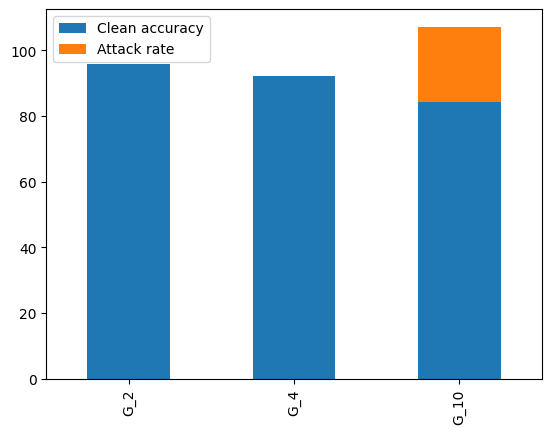

In [34]:
df.plot.bar(stacked=True)

In [35]:
df

,Clean accuracy,Attack rate
G_2,95.744349,0.000000
G_4,92.127825,0.015588
G_10,84.333593,22.790335
